<img src="Pics/FLEXPWR_logo_base_black-2.png" width="320" height="320" style="margin-left:auto; margin-right:auto"/>

# Ops Data Challenge: Managing A Renewables Portfolio
# Index

<a href= '#Imports'>Imports</a> <br>
<a href= '#Energy Trading in a Nutshell'>1. Intro: Energy Trading in a Nutshell</a> <br>
<a href= '#Data'>2. Data Sources</a> <br>
&nbsp;&nbsp; <a href= '#Assets'>2.1 Assets</a> <br>
&nbsp;&nbsp; <a href= '#IMB'>2.2 Imbalance, Measured Production & Market Price</a> <br>
&nbsp;&nbsp; <a href= '#Forecasts & MP'>2.3 Forecast & Measured Production</a> <br>
&nbsp;&nbsp; <a href= '#Wrangling'>2.4 Data Wrangling</a> <br>
<a href= '#Invoicing'>3. Invoicing</a> <br>
&nbsp;&nbsp; <a href= '#Infeed'>3.1 Infeed Payouts & Different Outcomes</a> <br>
&nbsp;&nbsp; <a href= '#Fee types'>3.2. Fees types & Different Outcomes</a> <br>
&nbsp;&nbsp; <a href= '#Unitary'>3.3 Unitary Net Amounts, VATs & Total Gross Amount</a> <br>
<a href= '#The Challenge'>4. The Challenge</a> <br>
&nbsp;&nbsp; <a href= '#Summary'>4.1. Summary: Portfolios performance and each single asset</a> <br>
&nbsp;&nbsp; <a href= '#Consultation'>4.2. Consultation Example - Optimizing Asset 1</a> <br>


<a id='Imports'></a>
## Imports

In [4]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
from datetime import datetime, timedelta

import Functions as fct

from IPython.display import display, HTML

In [5]:
#Use 90% of Screen width:
display(HTML("<style>.container { width:90% !important; }</style>"))

# Define decimal places shown in the notebook
pd.options.display.float_format = '{:,.2f}'.format

# Display the whole content of the data frame
pd.set_option('display.max_columns', None)      # Displays all columns
#pd.set_option('display.max_rows', None)       # Displays all rows

# Ignore warnings while plotting
import warnings
warnings.filterwarnings("ignore")

<a id='Energy Trading in a Nutshell'></a>
# 1. Introduction:
## Energy Trading in a Nutshell

Energy trading happens in an **exchange**, a market where traders working for energy producers 
(solar plants, nuclear power plants, ...) and consumers (B2C energy providers, big 
energy consuming industries like steel and trains...) submit orders to buy and sell energy.
One of the major exchanges in Europe is called [**EPEX**](https://en.wikipedia.org/wiki/European_Power_Exchange).

These orders consist of a volume (in Megawatt, rounded to one decimal) over a predefined period of
time, called **delivery period** (for example between 12:00, the **delivery start** and 13:00, 
the **delivery end**, on a given day) and for a given price per megawatt hour (referred to as mwh).

If the prices of two orders with opposite sides match, i.e the buy price is higher than the sell price, 
then, a trade is generated. 
For example if the orderbook contains an order to sell 10 mw for 10 euros/mwh and another trader 
submits an order to buy 5 mw for 11 euros/mwh, the orders are matched by the exchange and a trade is 
generated for 5mw at 10 euros/mwh.

The trading revenues are calculated by multiplying the volume with the price over all trades: for a buy trade, the revenue is 
negative, for a sell deal, the revenue is positive.

A list of trades that our trading floor executed are provided as a json. Volumes are in megawatt and prices are in euro per megawatt-hour.

We also provide and index price for the market, in a csv file. The index price is the volume weighted average price of all trades executed on the market, in euro per megawatt-hour.

<a id='Data'></a>
# 2. Data Sources
In total we are supplied with 5 different dataframes: Assets, Imbalance Penalty, Market Prices, Measured Production & Forecasted Prices & Quantities

<a id='Assets'></a>
### 2.1 Assets Base Data

With **base data** we usually mean static attributes of assets. These can be technical, contractual or financial.

In [9]:
# Assets Base Data:
ASSETS = pd.read_csv("C:/Users/sebas/python/OpsDataChallenge-main/assets_base_data.csv", sep= ';')
ASSETS.columns = ASSETS.columns.str.replace(' ', '')
ASSETS

,asset_id,metering_point_id,capacity__kw,technology,contract_begin,contract_end,price_model,price__eur_per_mwh,fee_model,fee__eur_per_mwh,fee_percent
0,a_1,mp_1,1000,solar,2024-01-01,NaN,fixed,10.00,fixed_as_produced,1.20,NaN
1,a_2,mp_2,2000,solar,2024-02-01,NaN,market,NaN,fixed_as_produced,1.40,NaN
2,a_3,mp_3,5000,wind,2024-07-01,NaN,fixed,15.00,fixed_for_capacity,0.60,NaN
3,a_4,mp_4,500,solar,2024-06-01,NaN,fixed,15.00,percent_of_market,NaN,15.00


In [10]:
# Imbalanced pros vs cons:
IMBALANCE = pd.read_csv("C:/Users/sebas/python/OpsDataChallenge-main/imbalance_penalty.csv", sep= ';')
IMBALANCE.columns = IMBALANCE.columns.str.replace(' ', '')

IMBALANCE['delivery_start']= pd.to_datetime(IMBALANCE['delivery_start'], dayfirst=False).dt.strftime("%d.%m.%Y %H:%M:%S")

# Market Price Data:
MARKET = pd.read_csv("C:/Users/sebas/python/OpsDataChallenge-main/market_index_price.csv", sep= ';')
MARKET.columns = MARKET.columns.str.replace(' ', '')
MARKET['delivery_start']= pd.to_datetime(MARKET['delivery_start'], dayfirst=False).dt.strftime("%d.%m.%Y %H:%M:%S")

# Measured Production per meter:
MEASURED = pd.read_csv("C:/Users/sebas/python/OpsDataChallenge-main/measured_20241013.csv", sep= ';')
MEASURED.columns = MEASURED.columns.str.replace(' ', '')
MEASURED['delivery_start']= pd.to_datetime(MEASURED['delivery_start'], dayfirst=False).dt.strftime("%d.%m.%Y %H:%M:%S")
MEASURED['total_measured_mwh'] = MEASURED.iloc[:,-4:].sum(axis=1)/1000

In [11]:
FORECAST = pd.read_json('C:/Users/sebas/python/OpsDataChallenge-main/trades.json')
FORECAST['delivery_start']= pd.to_datetime(FORECAST['delivery_start'], dayfirst=False).dt.strftime("%d.%m.%Y %H:%M:%S")
FORECAST['delivery_end']= pd.to_datetime(FORECAST['delivery_end'], dayfirst=False).dt.strftime("%d.%m.%Y %H:%M:%S")
FORECAST['execution_time']= pd.to_datetime(FORECAST['execution_time'], dayfirst=False).dt.strftime("%d.%m.%Y %H:%M:%S")

FORECAST.rename(columns={'price':'price_fcst_eur_per_mwh',
                         'quantity':'quantity_fcst_mwh'
                        }, inplace = True)

<a id='IMB'></a>
## 2.2 Imbalance Costs & Market Price

<a id='Imbalance'></a>
#### Imbalance Volumes & Cost: <br/>
* The electricity grid functions properly only when the production and consumption are balanced at all times and there are financial incentives to achieve that.<br/>
* If our forecasted production is different from the measured production (higher or lower), we have an **imbalance volume** and for that we have to pay a penalty.<br/>

#### Market Index Price
* For the "market" pricing model, we multiply the production of the asset, hour by hour, with the market index price.
* This price model is more sensitive to the market price fluctuations and can yield a better payout if the asset is producing at times where the price on the market is high.

In [15]:
fct.display_side_by_side([IMBALANCE.iloc[:5],MARKET.iloc[:5]], ['Imbalance penalty','Market Index Price'], tablespacing=30)

delivery_start,imbalance_penalty
12.10.2024 22:00:00,110.710000
12.10.2024 23:00:00,37.180000
13.10.2024 00:00:00,42.680000
13.10.2024 01:00:00,25.000000
13.10.2024 02:00:00,44.070000
delivery_start,market_index_price
12.10.2024 22:00:00,0.000000
12.10.2024 23:00:00,0.010000
13.10.2024 00:00:00,0.070000
13.10.2024 01:00:00,0.370000


<a id='Forecasts & MP'></a>
##  2.3 Forecasts and Measured Production

<a id='Forecasts'></a>
#### Forecasts:

* For each asset, FlexPower forecasts the electricity production **quantity_fcst_mwh**
* The price feature is not explained but we assume it is a predicted value as well
* This forecast allows FlexPower to know how much electricity will be available to sell on the markets for a given hour in the future.

<a id='Measured'></a>
#### Measured Production:
* Each asset is connected to the electricity grid through a so-called "metering point". 
* The production measured at this point is communicated to FlexPower by the Distribution System Operator (DSO) every day for the previous day. 
* The values here are used to invoice the asset owner and we get data for all assets at once, in a csv file. The unit is kilowatt.

In [19]:
fct.display_side_by_side([FORECAST.iloc[:5],MEASURED.iloc[:5]], ['Forecasted values for 24h','Measured production per meter'], tablespacing=10)

<a id='Wrangling'></a>
### 2.4. Data Wrangling:

#### Production per asset:
We summarize, transpose and join the grouped production per asset on hours to the assets base data:

In [22]:
ASSETS['production_kwh'] =  ASSETS['metering_point_id'].apply(lambda x: MEASURED.mp_1.sum() if x == 'mp_1' else 0) + ASSETS['metering_point_id'].apply(lambda x: MEASURED.mp_2.sum() if x == 'mp_2' else 0) + ASSETS['metering_point_id'].apply(lambda x: MEASURED.mp_3.sum() if x == 'mp_3' else 0) +ASSETS['metering_point_id'].apply(lambda x: MEASURED.mp_4.sum() if x == 'mp_4' else 0)
ASSETS['production_mwh'] = ASSETS['production_kwh'] / 1000

In [23]:
ASSETS[['asset_id','production_kwh','production_mwh']]

,asset_id,production_kwh,production_mwh
0,a_1,"1,598.00",1.60
1,a_2,"3,193.00",3.19
2,a_3,"74,868.00",74.87
3,a_4,798.00,0.80


####  Merge 'delivery_start' timelines
All four timebound tables share a common timeline. We can merge them on the delivery_start timeline;

In [25]:
FORECASTS = FORECAST.merge(MEASURED, on ='delivery_start', how='left')
FORECASTS = FORECASTS.merge(IMBALANCE, on ='delivery_start', how='left')
FORECASTS = FORECASTS.merge(MARKET, on ='delivery_start', how='left')

In [26]:
FORECASTS.head(5)

,delivery_end,delivery_start,execution_time,price_fcst_eur_per_mwh,quantity_fcst_mwh,side,trade_id,mp_1,mp_2,mp_3,mp_4,total_measured_mwh,imbalance_penalty,market_index_price
0,12.10.2024 23:00:00,12.10.2024 22:00:00,12.10.2024 21:31:00,83.77,1.90,sell,5261422,0.00,0.00,"2,430.00",0.00,2.43,110.71,0.00
1,13.10.2024 00:00:00,12.10.2024 23:00:00,12.10.2024 22:25:00,88.62,2.10,sell,1948684,0.00,0.00,"2,537.00",0.00,2.54,37.18,0.01
2,13.10.2024 01:00:00,13.10.2024 00:00:00,12.10.2024 23:20:00,73.09,2.80,sell,3086784,0.00,0.00,"2,590.00",0.00,2.59,42.68,0.07
3,13.10.2024 02:00:00,13.10.2024 01:00:00,13.10.2024 00:20:00,34.20,2.80,sell,670589,0.00,0.00,"2,818.00",0.00,2.82,25.00,0.37
4,13.10.2024 03:00:00,13.10.2024 02:00:00,13.10.2024 01:37:00,62.40,2.90,sell,989665,0.00,0.00,"3,096.00",0.00,3.10,44.07,0.51


In [27]:
# Seperate measured metering points and concatenate a new timeline table for visualisation

FOR = FORECASTS[['delivery_start','market_index_price','price_fcst_eur_per_mwh','mp_1']] 
FOR['mp'] = 'mp_1'
FOR.rename(columns={'mp_1':'production_kwh'}, inplace = True)

FOR1 = FORECASTS[['delivery_start','market_index_price','price_fcst_eur_per_mwh','mp_2']] 
FOR1['mp'] = 'mp_2'
FOR1.rename(columns={'mp_2':'production_kwh'}, inplace = True)

FOR2 = FORECASTS[['delivery_start','market_index_price','price_fcst_eur_per_mwh','mp_3']] 
FOR2['mp'] = 'mp_3'
FOR2.rename(columns={'mp_3':'production_kwh'}, inplace = True)

FOR3 = FORECASTS[['delivery_start','market_index_price','price_fcst_eur_per_mwh','mp_4']] 
FOR3['mp'] = 'mp_4'
FOR3.rename(columns={'mp_4':'production_kwh'}, inplace = True)

FOR = pd.concat([FOR, FOR1, FOR2, FOR3], axis=0)

print("Seperate metering points and concatenate a new timeline table for visualisation")

FOR.iloc[[0, 24, 48, 72]]

Seperate metering points and concatenate a new timeline table for visualisation


,delivery_start,market_index_price,price_fcst_eur_per_mwh,production_kwh,mp
0,12.10.2024 22:00:00,0.00,83.77,0.00,mp_1
0,12.10.2024 22:00:00,0.00,83.77,0.00,mp_2
0,12.10.2024 22:00:00,0.00,83.77,"2,430.00",mp_3
0,12.10.2024 22:00:00,0.00,83.77,0.00,mp_4


<a id='Invoicing'></a>
# 3. Invoicing
Here we create all necessary information for invoicing as well as potential payouts & costs if changing business models

<img src="Pics/PayYourInvoice-Square.png" width="640" height="440" style="margin-left:auto; margin-right:auto"/>

<a id='Infeed'></a>
### 3.1. Infeed Payouts & Different Outcomes:

I am calculating both outcomes for consultation on potential payout increases when chosing another payout type: </br>

* Fixed - We multiply the total produced volume with the price from the base data </br>
* Market - We multiply the production of the asset, hour by hour, with the market index price </br>

If there are no prices given for the fixed model we fill the missing values based on actuals.</br>
The column **Unitary Net Amount** shows the payout amount based on the asset's selected price model

In [30]:
# Fill in missing values based on given actuals:
ASSETS.fee_percent = ASSETS.fee_percent.fillna(15)
solarfee = ASSETS.query("technology == 'solar'").fee__eur_per_mwh.mean()
ASSETS.fee__eur_per_mwh = ASSETS.fee__eur_per_mwh.fillna(solarfee)

solarprice = ASSETS.query("technology == 'solar'").price__eur_per_mwh.mean()
ASSETS.price__eur_per_mwh = ASSETS.price__eur_per_mwh.fillna(solarprice)

In [31]:
ASSETS['infeed_payout_fixed'] = ASSETS.price__eur_per_mwh * ASSETS.production_mwh

result = []
for value in ASSETS["metering_point_id"]:
    if value == 'mp_1':
        result.append(sum(FORECASTS.mp_1/1000 * FORECASTS.market_index_price))
    elif value == 'mp_2':
        result.append(sum(FORECASTS.mp_2/1000 * FORECASTS.market_index_price))
    elif value == 'mp_3':
        result.append(sum(FORECASTS.mp_3/1000 * FORECASTS.market_index_price))
    else:
        result.append(sum(FORECASTS.mp_4/1000 * FORECASTS.market_index_price))

ASSETS['infeed_payout_market'] = result

# based on which payout type is selected, we decide for the unitary net ampount:
ASSETS['unitary_net_amount'] = ASSETS['infeed_payout_fixed'].where(ASSETS.price_model == 'fixed', ASSETS['infeed_payout_market'])

In [32]:
PAYOUT = ASSETS[['asset_id','price_model','unitary_net_amount','infeed_payout_market','infeed_payout_fixed']]
PAYOUT

,asset_id,price_model,unitary_net_amount,infeed_payout_market,infeed_payout_fixed
0,a_1,fixed,15.98,3.51,15.98
1,a_2,market,6.97,6.97,39.91
2,a_3,fixed,"1,123.02",680.70,"1,123.02"
3,a_4,fixed,11.97,1.74,11.97


#### Infeed Payout: Findings for consultation:

* Infeed payout fixed always yields higher payouts for the customer than the market approach
* Higher payouts for the customer on fixed prices might result in lower profits for Flex Power
* The market_index_price in peak production times is lower that the fixed price we are offering, which is a risk for Flex Power
* We should try to align (reduce) the fixed prices we offer with the index market price iver a longer period of time and weighted to peak production times.
* Market price model would also get more interesting, if the producers can strategically store produced energy and sell in times of high demand

<a id='Fee types'></a>
### 3.2. Fees Types & Different Outcomes:

I am calculating all 3 columns for consultation purposes. We can either save potential fee costs for our customers or maximize Flex Power's profits generated via fees.</br>
In the end it is a trade off between building good customer relationships, risk mitigation because of volatile prices & building a sustainable business model for Flex Power.</br>

* Fixed Fee: Asset 1 & 2 decided on a fixed fee which is cost optimizing for them
* Capacity Fee: Asset 3 decided on the capacity fee which is cost optimizing for them
* Percentage Market Fee: Asset 4 decided on a percentage market fee and could reduce cost with on fixed fee

In [35]:
ASSETS['fixed_fee'] = ASSETS.fee__eur_per_mwh * ASSETS.production_mwh
ASSETS['capacity_fee'] = ASSETS.capacity__kw/1000 * ASSETS.fee__eur_per_mwh
ASSETS['percent_market_fee'] = ASSETS.production_mwh * FORECASTS.market_index_price.mean() * ASSETS.fee_percent / 100

ASSETS['chosen'] = ASSETS['capacity_fee'].where(ASSETS.fee_model == 'fixed_for_capacity', ASSETS['fixed_fee'])
ASSETS['chosen_fee'] = ASSETS['percent_market_fee'].where(ASSETS.fee_model == 'percent_of_market', ASSETS['chosen'])

ASSETS.drop(['chosen'], axis=1, inplace =True)

In [36]:
FEES = ASSETS[['asset_id','fee_model','fixed_fee','capacity_fee','percent_market_fee','chosen_fee']]
FEES

,asset_id,fee_model,fixed_fee,capacity_fee,percent_market_fee,chosen_fee
0,a_1,fixed_as_produced,1.92,1.20,2.64,1.92
1,a_2,fixed_as_produced,4.47,2.80,5.28,4.47
2,a_3,fixed_for_capacity,44.92,3.00,123.89,3.00
3,a_4,percent_of_market,1.04,0.65,1.32,1.32


#### Fee Types: Findings for consultation:

* Generaly the **capacity fee** model seems to be cost saving for big & constant energy producers like wind. </br>
* **Percentage market fee** is optimal if you can supply energy at times of high prices, e.g. if you can combine solar production with storage.</br>
* The **fixed fee** seems to be the optimal choice for new, small or solar producers without storage capacity. It reduces market entry risks when building a new production facility and yields constant & calculatable income.

<a id='Unitary'></a>
### 3.3 Unitary Net Amounts, VATs & Total Gross Amount

In [39]:
# VAT
ASSETS['VAT_unitary_amount'] = ASSETS['unitary_net_amount'] * 0.19
ASSETS['VAT_chosen_fee'] = ASSETS['chosen_fee'] * 0.19
ASSETS['total_gross_amount'] = ASSETS['unitary_net_amount'] + ASSETS['VAT_unitary_amount'] - (ASSETS['chosen_fee'] + ASSETS['VAT_chosen_fee'])

In [40]:
AMOUNTS = ASSETS[['asset_id','price_model','price__eur_per_mwh','unitary_net_amount','VAT_unitary_amount','chosen_fee','VAT_chosen_fee','total_gross_amount']]
AMOUNTS

,asset_id,price_model,price__eur_per_mwh,unitary_net_amount,VAT_unitary_amount,chosen_fee,VAT_chosen_fee,total_gross_amount
0,a_1,fixed,10.00,15.98,3.04,1.92,0.36,16.73
1,a_2,market,12.50,6.97,1.32,4.47,0.85,2.97
2,a_3,fixed,15.00,"1,123.02",213.37,3.00,0.57,"1,332.82"
3,a_4,fixed,15.00,11.97,2.27,1.32,0.25,12.67


<a id='The Challenge'></a>
## 4. The Challenge

Your goal is to help FlexPower make sense of all this data, in particular:

### Compute trading revenues:

* The trading revenues are calculated by multiplying the volume with the price over all trades
* I chose the market index price to construct the trading revenues, as the fcst price seems to be exceeding the
* We only have sell deals in the dataframes, so the trading revenue is positive

In [43]:
FORECASTS['trading_revenue_mp1'] = FORECASTS['market_index_price'] * FORECASTS['mp_1']/1000
FORECASTS['trading_revenue_mp2'] = FORECASTS['market_index_price'] * FORECASTS['mp_2']/1000
FORECASTS['trading_revenue_mp3'] = FORECASTS['market_index_price'] * FORECASTS['mp_3']/1000
FORECASTS['trading_revenue_mp4'] = FORECASTS['market_index_price'] * FORECASTS['mp_4']/1000

#### Trading revenues per asset per hour

In [45]:
FORECASTS['trading_revenue_tot'] = FORECASTS[['trading_revenue_mp1','trading_revenue_mp2','trading_revenue_mp3','trading_revenue_mp4']].sum(axis=1)
print('Flex Trades total trade volume for all 4 assets on market index prices for October 13th is {0}€.'.format(FORECASTS['trading_revenue_tot'].sum().astype(int)))
print('Rounded up, it is roughly {0}k€. I am assuming all production gets sold directly.'.format(round(FORECASTS['trading_revenue_tot'].sum().astype(int)/1000,2)))
FORECASTS[['delivery_start','trading_revenue_mp1','trading_revenue_mp2','trading_revenue_mp3','trading_revenue_mp4','trading_revenue_tot']].head(5)

Flex Trades total trade volume for all 4 assets on market index prices for October 13th is 692€.
Rounded up, it is roughly 0.69k€. I am assuming all production gets sold directly.


,delivery_start,trading_revenue_mp1,trading_revenue_mp2,trading_revenue_mp3,trading_revenue_mp4,trading_revenue_tot
0,12.10.2024 22:00:00,0.00,0.00,0.00,0.00,0.00
1,12.10.2024 23:00:00,0.00,0.00,0.03,0.00,0.03
2,13.10.2024 00:00:00,0.00,0.00,0.18,0.00,0.18
3,13.10.2024 01:00:00,0.00,0.00,1.04,0.00,1.04
4,13.10.2024 02:00:00,0.00,0.00,1.58,0.00,1.58


In [46]:
result = []
for value in ASSETS["metering_point_id"]:
    if value == 'mp_1':
        result.append(sum(FORECASTS.trading_revenue_mp1))
    elif value == 'mp_2':
        result.append(sum(FORECASTS.trading_revenue_mp2))
    elif value == 'mp_3':
        result.append(sum(FORECASTS.trading_revenue_mp3))
    else:
        result.append(sum(FORECASTS.trading_revenue_mp4))
ASSETS['trading_revenue_per_asset'] = result

#### Trading revenues per asset summarized:

In [48]:
ASSETS[['asset_id', 'trading_revenue_per_asset']]

,asset_id,trading_revenue_per_asset
0,a_1,3.51
1,a_2,6.97
2,a_3,680.70
3,a_4,1.74


### Compute Imbalance Cost for each asset:
* Only the total imbalance penalty, our total forecast for all assets combined and the differend measured production per asset is given.</a>
* I construct the Imbalance volume as difference between forecast and actual measured production.</br>
* Afterwards I apply the share of produced energy to the penalty to construct the imbalance cost per asset: </a>

In [50]:
FORECASTS['imbalance_volume'] = abs(FORECASTS['total_measured_mwh'] - FORECASTS['quantity_fcst_mwh'])
FORECASTS['imbalance_penalty_total'] = FORECASTS['imbalance_volume'] * FORECASTS['imbalance_penalty'] 

In [51]:
FORECASTS['imbalance_eur_mp_1'] = FORECASTS['imbalance_penalty_total'] * FORECASTS['mp_1']/(FORECASTS['total_measured_mwh']*1000)
FORECASTS['imbalance_eur_mp_2'] = FORECASTS['imbalance_penalty_total'] * FORECASTS['mp_2']/(FORECASTS['total_measured_mwh']*1000)
FORECASTS['imbalance_eur_mp_3'] = FORECASTS['imbalance_penalty_total'] * FORECASTS['mp_3']/(FORECASTS['total_measured_mwh']*1000)
FORECASTS['imbalance_eur_mp_4'] = FORECASTS['imbalance_penalty_total'] * FORECASTS['mp_4']/(FORECASTS['total_measured_mwh']*1000)

In [52]:
FORECASTS[['delivery_start','imbalance_eur_mp_1','imbalance_eur_mp_2','imbalance_eur_mp_3','imbalance_eur_mp_4']].head(5)

,delivery_start,imbalance_eur_mp_1,imbalance_eur_mp_2,imbalance_eur_mp_3,imbalance_eur_mp_4
0,12.10.2024 22:00:00,0.00,0.00,58.68,0.00
1,12.10.2024 23:00:00,0.00,0.00,16.25,0.00
2,13.10.2024 00:00:00,0.00,0.00,8.96,0.00
3,13.10.2024 01:00:00,0.00,0.00,0.45,0.00
4,13.10.2024 02:00:00,0.00,0.00,8.64,0.00


In [53]:
result = []
for value in ASSETS["metering_point_id"]:
    if value == 'mp_1':
        result.append(sum(FORECASTS.imbalance_eur_mp_1))
    elif value == 'mp_2':
        result.append(sum(FORECASTS.imbalance_eur_mp_2))
    elif value == 'mp_3':
        result.append(sum(FORECASTS.imbalance_eur_mp_3))
    else:
        result.append(sum(FORECASTS.imbalance_eur_mp_4))
ASSETS['Imbalance_per_asset'] = result

In [54]:
ASSETS[['asset_id','Imbalance_per_asset']]

,asset_id,Imbalance_per_asset
0,a_1,0.80
1,a_2,1.60
2,a_3,718.02
3,a_4,0.40


### Compute invoices for each asset:

Following components are used when computing the total gross amount for our customers. </br>
For transparancy reasons this information should be visible on the invoices we send to customers:

* Asset_id (customer no)
* The selected price model and price customers gets paid by Flex Power for a fixed price model
* The average market index price for the given timeframe
* The unitary_net_amount based on the selected price type + the separated VATs
* Total Gross Amount as payout deducted by the chosen fee

With the table below we can automate invoice creation on any given template

In [57]:
ASSETS['market_index_price_avg'] = FORECASTS.market_index_price.mean()
ASSETS[['asset_id','price_model','price__eur_per_mwh','market_index_price_avg','unitary_net_amount','VAT_unitary_amount','chosen_fee','VAT_chosen_fee','total_gross_amount']]

,asset_id,price_model,price__eur_per_mwh,market_index_price_avg,unitary_net_amount,VAT_unitary_amount,chosen_fee,VAT_chosen_fee,total_gross_amount
0,a_1,fixed,10.00,11.03,15.98,3.04,1.92,0.36,16.73
1,a_2,market,12.50,11.03,6.97,1.32,4.47,0.85,2.97
2,a_3,fixed,15.00,11.03,"1,123.02",213.37,3.00,0.57,"1,332.82"
3,a_4,fixed,15.00,11.03,11.97,2.27,1.32,0.25,12.67


<a id='Summary'></a>
### 4.1. Summary: Portfolios performance and each single asset

Traditionally you see the highest energy prices in the afterno0n & evening, where there is 0 solar production.
You can capitalize on market solutions, if you can strategically store your energy production and sell at higher prices.


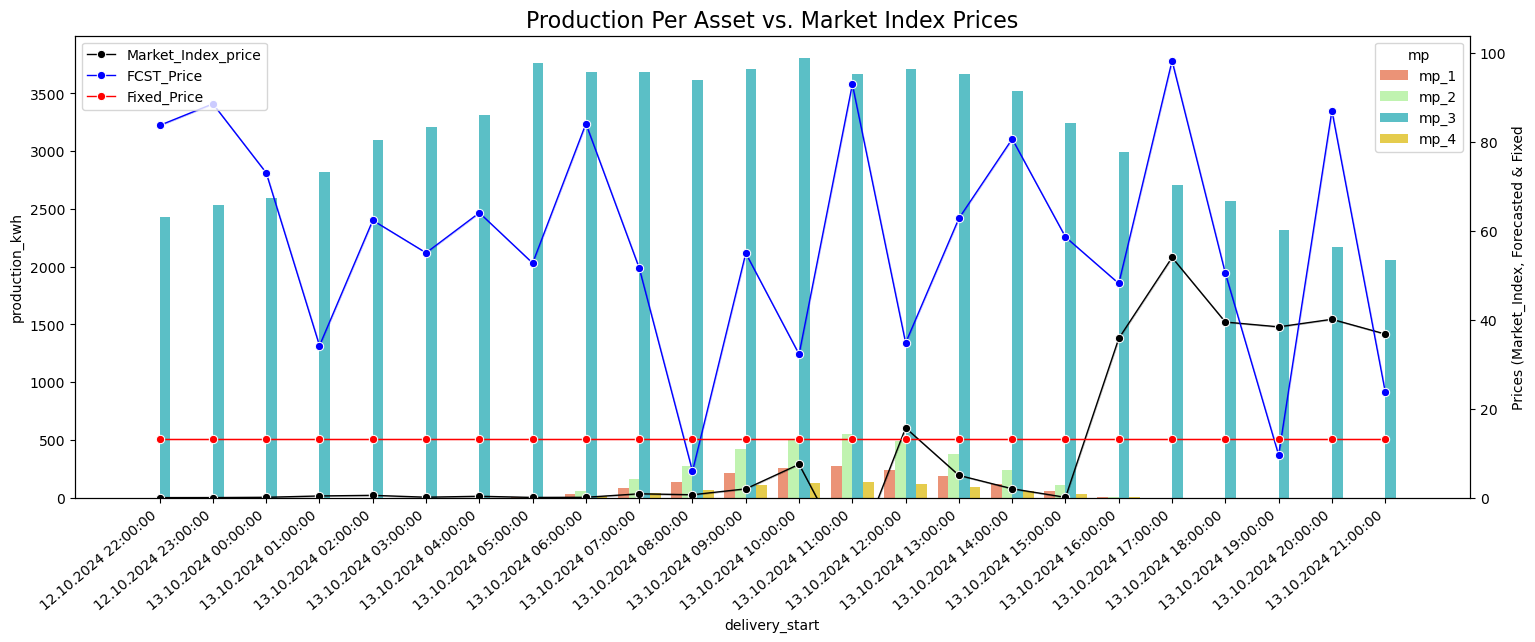

In [59]:
print("Traditionally you see the highest energy prices in the afterno0n & evening, where there is 0 solar production.")
print("You can capitalize on market solutions, if you can strategically store your energy production and sell at higher prices.")

fct.Price_prod_graph(FOR, ASSETS, ['#ff6b3d','#aaff8e','#1cc3ce','#ffd500'], 'Production Per Asset vs. Market Index Prices', (18,6))

+ The average price in the forecast json dataframe is higher than market index prices or the fixed prices
+ The forecast accuracy for prices could be improved:
+ The differences between forecasted prices, market index price and fixed prices should be optimized for individual asset types:
    + Is there storage capacity?
    + Wind energy produces a stable & high total gross amount, but the fee income is comparably low
    + Better arbitrage possibilities with Solar + Storage? (See consultation example below)

In [61]:
fct.display_side_by_side([ASSETS[['asset_id','price_model','price__eur_per_mwh']] , FOR.groupby(["mp"], as_index=False)["market_index_price"].mean(), FOR.groupby(["mp"], as_index=False)["price_fcst_eur_per_mwh"].mean()], ['Measured Production','Market Index Price','Forecast Price'], tablespacing=30)

#### Performance:

+ For performance checks & consultation, we created all fee types and infeed payouts, unrelated to the contractual situation:
    + Asset_3 chose the cost-optimizing fee model, the other could save cost by changing to the capacity fee model
    + 3 assets chose the payout maximizing price model, only asset_2 could increase it's payout by changing to a fixed pricing model

All those checks and the consultation requires a profound knowledge of the Flex Power business model:

* Are fees the only soure of creating revenue for Flex Power?
* Is Flex Power willing to invest in storage capacity if we can, contractualy, benefit from it long term?
* Does Flex Power benefit from the gap between fixed price and actual trade prices?
* How is Flex Power weighting winning new assets vs. building sustainable business relationships vs. profit maximization?
* Are there pareto efficient allocations already or are there possibilities to create "win-win situations"

<a id='Consultation'></a>
### 4.2 Consultation Example - Optimizing Asset 1
Arbitrage with fully usable storage capacity:

In [65]:
A1 = ASSETS.query("asset_id == 'a_1'")
print("Asset 1: Currently selected business model")
A1[['asset_id','production_kwh','price_model','fee_model','price__eur_per_mwh','market_index_price_avg','unitary_net_amount','VAT_unitary_amount','chosen_fee','VAT_chosen_fee','total_gross_amount']]

Asset 1: Currently selected business model


,asset_id,production_kwh,price_model,fee_model,price__eur_per_mwh,market_index_price_avg,unitary_net_amount,VAT_unitary_amount,chosen_fee,VAT_chosen_fee,total_gross_amount
0,a_1,"1,598.00",fixed,fixed_as_produced,10.00,11.03,15.98,3.04,1.92,0.36,16.73


In [66]:
Price_w_storage = round(FORECASTS.query("market_index_price > 10").market_index_price.mean(),2)

print("If asset_1 could save all its energy production and sell at (evening) times where the market_index_prices exceeds the fixed price")
print("Asset_1 could realize an avg index_price of {0}€".format(Price_w_storage))
print("The new unitary net amount of {0}€ is roughly 3.7 times higher than the old ".format(round(A1.production_mwh.iat[0] * Price_w_storage)))

If asset_1 could save all its energy production and sell at (evening) times where the market_index_prices exceeds the fixed price
Asset_1 could realize an avg index_price of 37.21€
The new unitary net amount of 59€ is roughly 3.7 times higher than the old 


In [67]:
print("Flex Power would not benefit from strategically storing production under fixed or capacity fees.")
print("If storage is available for the asset, Flex Power needs to recalculate and proactively adjust the fixed fees to increase own profits")
print("To create a pareto optimum, Flex Power could offer the arbitrage business model in combination with the market fee model:")
print("The fee would increase to {0}€ compared to {1}€ on fixed as produced".format(round((A1.production_mwh * Price_w_storage * A1.fee_percent / 100).iat[0],2), round(A1.chosen_fee.iat[0],2)))
print("Both parties would benefit for the intital cost of building up storage capacity".format(round((A1.production_mwh * Price_w_storage * A1.fee_percent / 100).iat[0],2)))

Flex Power would not benefit from strategically storing production under fixed or capacity fees.
If storage is available for the asset, Flex Power needs to recalculate and proactively adjust the fixed fees to increase own profits
To create a pareto optimum, Flex Power could offer the arbitrage business model in combination with the market fee model:
The fee would increase to 8.92€ compared to 1.92€ on fixed as produced
Both parties would benefit for the intital cost of building up storage capacity
